# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

In [2]:
import pandas as pd
import essentia
import essentia.standard as estd
import matplotlib.pyplot as plt
from IPython.display import display, Audio

In [40]:
# Define here our sound analysis function
# NOTE: remember that if you update this function and want to run a new analysis you'll need to re-run both 
# this cell and the cells below that carry out the audio analysis and that call the analysis function. 
# After analyzing the source collection or the target file, make sure to correct descriptors have been 
# extracted by checking the DataFrame contents. DataFrame contents can be printed on screen as a table 
# using 'display(data_frame_object)'

#very basic implementation, could be improved, for example, taking scale type in account?
#also, this is not relative to C and not completely simetrical
def translate_key_to_number(key):
    keys_to_number = {'C':0, 'G':1, 'D':2, 'A':3,'E':4, 'B':5, 'F#':6, 'C#':-5, 'G#':-4, 'D#':-3, 'A#':-2, 'F':-1}
    return keys_to_number[key]

def analyze_sound(audio_path, frame_size=None, audio_id=None):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will 
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as 
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be 
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file
    
    # Load audio file
    #loader = estd.MonoLoader(filename=audio_path)
    loader = estd.EqloudLoader(filename=audio_path)

    audio = loader()
    
    # Some processing of frame_size parameter to avoid later problems
    if frame_size is None:
        frame_size = len(audio)  # If no frame_size is given use no frames (analyze all audio at once)
    if frame_size % 2 != 0:
        frame_size = frame_size + 1 # Make frame size even
    
    # Calculate the start and end samples for each equally-spaced audio frame
    frame_start_samples = range(0, len(audio), frame_size)
    frame_start_end_samples = zip(frame_start_samples[:-1], frame_start_samples[1:])


    key_algo = estd.KeyExtractor()
    key, scale, key_strength = key_algo(audio)
    global_track_key = translate_key_to_number(key)
    
    # Iterate over audio frames and analyze each one
    for count, (fstart, fend) in enumerate(frame_start_end_samples):
        
        # Get corresponding audio chunk and initialize dictionary to sotre analysis results with some basic metadata
        frame = audio[fstart:fend]
        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, count),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }
        
        # Extract loudness
        loudness_algo = estd.Loudness()
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        # Extract MFCC coefficients
        w_algo = estd.Windowing(type = 'hann')
        spectrum_algo = estd.Spectrum()
        mfcc_algo = estd.MFCC()
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
        
        # Extract other features here and add to 'frame_output' dictionary
        # key extractor
        key_algo = estd.KeyExtractor()
        key, scale, key_strength = key_algo(frame)
        frame_output.update({'frame_key': translate_key_to_number(key),
                             'global_track_key':global_track_key,
                             'scale': scale,
                             'key_strength': key_strength})

        
        # Add frame analysis results to output
        analysis_output.append(frame_output)

    return analysis_output
    

## Analyze source collection

In [11]:
DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME = 'dataframe_source.csv'  # DataFrame file where to store the results of our analysis
FRAME_SIZE = 8820
    
def analyze_source_collection(dataframe_source, dataframe_results, frame_size=FRAME_SIZE):
    print('frame size ', frame_size )
    # Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
    df = pd.read_csv(open(dataframe_source), index_col=0)
    analyses = []
    for i in range(0, len(df)):
        sound = df.iloc[i]  # Get DataFrame sound at position 'i'
        print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
        analysis_output = analyze_sound(sound['path'], frame_size=FRAME_SIZE, audio_id=sound['freesound_id'])  # Split audio in chunks of 200ms (44100/5 samples)
        analyses += analysis_output

    # Store analysis results in a new Pandas DataFrame and save it
    df_source = pd.DataFrame(analyses)
    df_source.to_csv(dataframe_results)
    print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), dataframe_results))

    display(df_source)  # Show DataFrane contents
    df_source.describe()  # Show some statistics of numerical fields in the DataFrame
    return df


analyze_source_collection(DATAFRAME_FILENAME, DATAFRAME_SOURCE_FILENAME)



frame size  8820


FileNotFoundError: [Errno 2] No such file or directory: 'dataframe.csv'

## Analyze the target sound file

Analyzing target sound 262350__stereo-surgeon__grinder-drum-loop.wav
Saved target dataframe with 147 entries! dataframe_target.csv


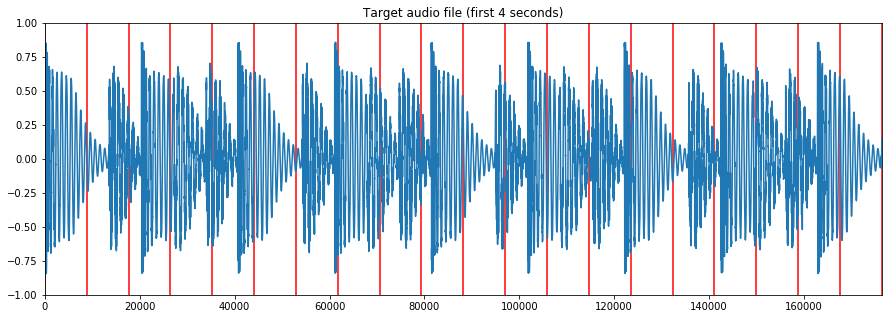

,end_sample,freesound_id,id,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,start_sample
0,8820,None,None_f0,0.016481,-912.375793,227.141754,17.782658,14.453064,11.978928,70.689041,6.608189,18.200165,25.355606,19.362217,13.890837,11.087498,15.169771,262350__stereo-surgeon__grinder-drum-loop.wav,0
1,17640,None,None_f1,0.007869,-687.080627,189.494156,18.008495,7.835981,-0.814304,-6.119999,10.463284,5.780128,12.194845,2.906433,17.150248,3.836746,2.818661,262350__stereo-surgeon__grinder-drum-loop.wav,8820
2,26460,None,None_f2,0.015003,-629.191772,159.515259,3.603485,10.685011,-12.620123,24.398865,44.562828,23.446365,24.413643,2.514433,8.923550,20.551584,-6.142408,262350__stereo-surgeon__grinder-drum-loop.wav,17640
3,35280,None,None_f3,0.011783,-776.993652,213.831024,11.801357,9.926826,8.818817,-11.526085,-14.749050,15.721851,31.945877,2.564117,13.642075,9.784691,23.141233,262350__stereo-surgeon__grinder-drum-loop.wav,26460
4,44100,None,None_f4,0.013545,-616.678162,149.881943,-0.139301,6.152349,-18.404381,17.397446,39.538273,20.338825,21.194437,-3.588320,4.172234,16.158289,-9.655806,262350__stereo-surgeon__grinder-drum-loop.wav,35280
5,52920,None,None_f5,0.010096,-1022.262939,145.248962,11.303616,14.761047,18.306763,99.636841,52.801407,25.047123,19.027451,22.909443,23.898783,18.667080,12.567591,262350__stereo-surgeon__grinder-drum-loop.wav,44100
6,61740,None,None_f6,0.010430,-726.911133,216.713608,18.366222,9.563995,2.277847,-21.926773,-2.288239,5.953606,13.409815,6.003902,9.805363,16.021832,11.766304,262350__stereo-surgeon__grinder-drum-loop.wav,52920
7,70560,None,None_f7,0.016835,-817.346191,192.341156,13.532913,12.947178,2.793793,10.612282,43.506020,23.464035,15.099365,12.168568,28.128809,16.503448,2.659775,262350__stereo-surgeon__grinder-drum-loop.wav,61740
8,79380,None,None_f8,0.009343,-684.241272,193.516479,8.889746,-2.246521,5.236567,-10.480309,0.139172,18.948696,14.592796,4.590237,15.178684,14.224636,10.501005,262350__stereo-surgeon__grinder-drum-loop.wav,70560
9,88200,None,None_f9,0.015771,-666.343689,167.627625,8.099909,12.613567,-11.260674,29.054890,44.841080,23.113892,23.208317,2.169083,10.748915,23.003519,-3.282627,262350__stereo-surgeon__grinder-drum-loop.wav,79380


,end_sample,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,start_sample
count,1.470000e+02,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,1.470000e+02
mean,6.526800e+05,0.010611,-741.194765,151.750358,10.879126,4.619174,-2.294727,2.701394,26.691574,11.407145,17.868998,9.729604,10.229332,12.084202,4.876471,6.438600e+05
std,3.755498e+05,0.004316,126.279285,42.501587,8.223984,6.903667,9.336212,50.847979,27.054610,18.514661,14.478411,14.584409,9.599035,8.878799,10.253712,3.755498e+05
min,8.820000e+03,0.000019,-1138.357300,0.054882,-18.434673,-16.944710,-20.037846,-132.812393,-74.098473,-54.044147,-35.840565,-40.845459,-34.908962,-27.015514,-21.575787,0.000000e+00
25%,3.307500e+05,0.007872,-784.819183,135.877167,4.930024,0.930128,-10.618545,-26.889775,15.766788,7.366062,16.690987,-0.112516,6.278240,9.028919,-2.629093,3.219300e+05
50%,6.526800e+05,0.011450,-693.971313,152.343063,11.091829,4.585035,-0.453133,-6.119999,38.201832,16.295853,22.102619,10.437927,11.692421,13.540495,6.690327,6.438600e+05
75%,9.746100e+05,0.013727,-654.883331,180.618301,16.730885,8.093996,3.847141,24.397156,45.108627,23.303320,24.626335,21.132659,15.540685,17.974619,12.552691,9.657900e+05
max,1.296540e+06,0.018259,-599.645447,229.604462,30.213848,21.801502,21.726311,117.380859,60.481056,42.558659,41.835251,32.909794,28.128809,32.444920,25.270288,1.287720e+06


In [22]:
TARGET_SOUND_PATH = '262350__stereo-surgeon__grinder-drum-loop.wav'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'  # DataFrame file where to store the analysis results of the target audio

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))
print('frame size  {0}'.format(FRAME_SIZE))
target_analysis = analyze_sound(TARGET_SOUND_PATH, frame_size=FRAME_SIZE)  # Also split audio in chunks of 200ms (44100/5 samples) 
df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))

# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red')
plt.axis([0, min(len(audio), 44100 * 4), -1, 1])
plt.title('Target audio file (first 4 seconds)')
plt.show()

display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame

# My contribution

Please find my contribution below

frame size  8820
Analyzing sound with id 44845 [1/41]
Analyzing sound with id 429954 [2/41]
Analyzing sound with id 361680 [3/41]
Analyzing sound with id 220449 [4/41]
Analyzing sound with id 438907 [5/41]
Analyzing sound with id 268603 [6/41]
Analyzing sound with id 31992 [7/41]
Analyzing sound with id 377029 [8/41]
Analyzing sound with id 220377 [9/41]
Analyzing sound with id 442291 [10/41]
Analyzing sound with id 412357 [11/41]
Analyzing sound with id 337895 [12/41]
Analyzing sound with id 342016 [13/41]
Analyzing sound with id 161167 [14/41]
Analyzing sound with id 121023 [15/41]
Analyzing sound with id 121031 [16/41]
Analyzing sound with id 257528 [17/41]
Analyzing sound with id 153644 [18/41]
Analyzing sound with id 134013 [19/41]
Analyzing sound with id 42710 [20/41]
Analyzing sound with id 395155 [21/41]
Analyzing sound with id 395156 [22/41]
Analyzing sound with id 395158 [23/41]
Analyzing sound with id 395159 [24/41]
Analyzing sound with id 395161 [25/41]
Analyzing sound with

,end_sample,frame_key,freesound_id,global_track_key,id,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,start_sample
0,8820,-1,44845,2,44845_f0,0.508120,4.074033e-07,-1138.420044,0.000011,-0.000027,...,0.000080,-0.000061,0.000023,-0.000027,-0.000053,-0.000046,-0.000023,deliverables/harmony/44845_13258-hq.ogg,major,0
1,17640,-1,44845,2,44845_f1,0.647881,4.106611e-06,-1110.491943,16.244396,0.757671,...,7.482807,3.705582,-13.210594,-7.526642,-0.496330,-7.754623,-6.693207,deliverables/harmony/44845_13258-hq.ogg,major,8820
2,26460,-1,44845,2,44845_f2,0.614335,1.319633e-05,-1051.135742,53.112133,-1.963764,...,-1.562786,-2.023300,-21.088295,-7.948563,-2.704437,-11.081451,-6.589714,deliverables/harmony/44845_13258-hq.ogg,major,17640
3,35280,-2,44845,2,44845_f3,0.667010,4.574493e-05,-973.532593,55.965157,-4.145176,...,19.387486,-3.996857,-22.530693,-1.752880,-16.920868,-15.076881,1.173187,deliverables/harmony/44845_13258-hq.ogg,minor,26460
4,44100,2,44845,2,44845_f4,0.626802,7.627402e-05,-942.344482,61.871521,-0.874454,...,26.821476,-13.482067,-20.189583,4.047962,-15.218666,-11.494576,-0.401062,deliverables/harmony/44845_13258-hq.ogg,minor,35280
5,52920,-3,44845,2,44845_f5,0.738271,6.613307e-05,-942.439209,63.795853,-11.880617,...,35.034901,-7.663773,-20.375679,-2.390575,-17.890503,-4.047943,-2.320312,deliverables/harmony/44845_13258-hq.ogg,minor,44100
6,61740,0,44845,2,44845_f6,0.589779,5.825559e-05,-953.616150,84.180397,-6.300272,...,18.586506,-10.030106,-29.020763,-1.055141,-15.931702,-10.099709,1.560379,deliverables/harmony/44845_13258-hq.ogg,major,52920
7,70560,-2,44845,2,44845_f7,0.640606,6.676412e-05,-938.245972,90.195930,-6.085577,...,12.239460,-4.800232,-15.820580,-1.096478,-24.359970,-9.881927,5.243088,deliverables/harmony/44845_13258-hq.ogg,major,61740
8,79380,-2,44845,2,44845_f8,0.711895,7.081236e-05,-928.033325,97.463509,-9.143526,...,12.794483,-17.441616,-26.027584,1.380955,-19.807755,-10.271622,-6.603416,deliverables/harmony/44845_13258-hq.ogg,major,70560
9,88200,-4,44845,2,44845_f9,0.347780,9.932265e-05,-914.112915,94.062233,-6.329069,...,21.856297,-14.508419,-25.423580,-4.027630,-14.825790,-4.916420,-8.252022,deliverables/harmony/44845_13258-hq.ogg,major,79380


frame size  8820
Analyzing sound with id 410514 [1/60]
Analyzing sound with id 190613 [2/60]
Analyzing sound with id 384668 [3/60]
Analyzing sound with id 459895 [4/60]
Analyzing sound with id 118524 [5/60]
Analyzing sound with id 318330 [6/60]
Analyzing sound with id 96016 [7/60]
Analyzing sound with id 264285 [8/60]
Analyzing sound with id 397016 [9/60]
Analyzing sound with id 324236 [10/60]
Analyzing sound with id 455633 [11/60]
Analyzing sound with id 323261 [12/60]
Analyzing sound with id 271078 [13/60]
Analyzing sound with id 269719 [14/60]
Analyzing sound with id 410149 [15/60]
Analyzing sound with id 137779 [16/60]
Analyzing sound with id 198100 [17/60]
Analyzing sound with id 156020 [18/60]
Analyzing sound with id 340467 [19/60]
Analyzing sound with id 194021 [20/60]
Analyzing sound with id 106144 [21/60]
Analyzing sound with id 116615 [22/60]
Analyzing sound with id 234425 [23/60]
Analyzing sound with id 445068 [24/60]
Analyzing sound with id 185615 [25/60]
Analyzing sound wi

,end_sample,frame_key,freesound_id,global_track_key,id,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,start_sample
0,8820,-1,410514,5,410514_f0,0.695623,7.987455e-04,-858.915466,147.011292,-15.481024,...,40.361713,-25.965527,-33.245922,-9.084724,-28.837234,-16.057549,-22.208794,deliverables/drums/410514_5121236-hq.ogg,minor,0
1,17640,2,410514,5,410514_f1,0.503528,1.865017e-04,-930.755432,90.472176,-12.946028,...,19.696842,-28.999050,-35.054226,-10.301567,-22.028671,-9.169533,-13.898651,deliverables/drums/410514_5121236-hq.ogg,major,8820
2,26460,5,410514,5,410514_f2,0.591356,4.649045e-06,-1111.135742,29.169109,1.678005,...,-15.558056,-25.491634,-19.858437,-5.114193,8.158098,12.749798,8.744280,deliverables/drums/410514_5121236-hq.ogg,minor,17640
3,35280,5,410514,5,410514_f3,0.617631,1.018190e-06,-1133.863647,4.557934,0.068607,...,-4.509808,-6.364456,-4.493599,-0.041958,4.350754,6.128170,4.318550,deliverables/drums/410514_5121236-hq.ogg,minor,26460
4,44100,5,410514,5,410514_f4,0.603811,4.808248e-07,-1136.623901,1.799847,0.069485,...,-1.768536,-2.508942,-1.786690,-0.042431,1.693802,2.415791,1.729584,deliverables/drums/410514_5121236-hq.ogg,minor,35280
5,52920,5,410514,5,410514_f5,0.582503,1.957297e-07,-1138.420044,0.000011,-0.000027,...,0.000080,-0.000061,0.000023,-0.000027,-0.000053,-0.000046,-0.000023,deliverables/drums/410514_5121236-hq.ogg,minor,44100
6,61740,5,410514,5,410514_f6,0.574366,7.825795e-08,-1138.420044,0.000011,-0.000027,...,0.000080,-0.000061,0.000023,-0.000027,-0.000053,-0.000046,-0.000023,deliverables/drums/410514_5121236-hq.ogg,minor,52920
7,70560,5,410514,5,410514_f7,0.578103,1.709017e-08,-1138.420044,0.000011,-0.000027,...,0.000080,-0.000061,0.000023,-0.000027,-0.000053,-0.000046,-0.000023,deliverables/drums/410514_5121236-hq.ogg,minor,61740
8,8820,5,190613,1,190613_f0,0.555186,1.189657e-03,-817.349670,70.108459,12.034065,...,69.808975,16.352364,33.153351,24.340996,17.507334,19.312679,9.454540,deliverables/drums/190613_3172867-hq.ogg,minor,0
9,17640,6,190613,1,190613_f1,0.404588,1.815721e-04,-826.231018,59.032768,1.548508,...,48.734924,-7.885956,12.929007,6.994301,6.046421,7.511181,-4.718338,deliverables/drums/190613_3172867-hq.ogg,minor,8820


8820
Analyzing target sound deliverables/target_burial_beat.wav
Saved target dataframe with 272 entries! deliverables/dataframes/dataframe_target_burial_beat.csv


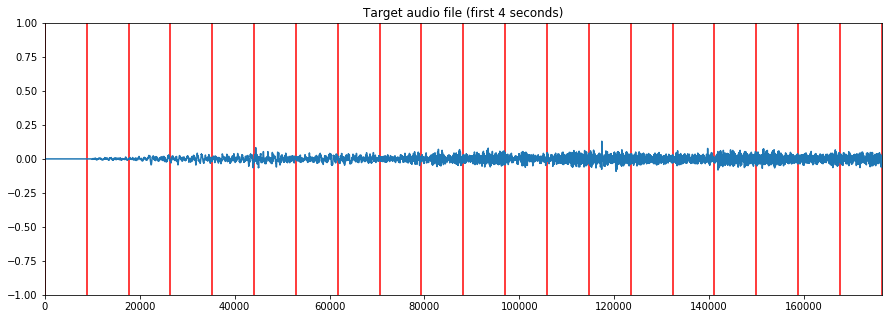

Analyzing target sound deliverables/target_spotlight_nobeat.wav
Saved target dataframe with 750 entries! deliverables/dataframes/dataframe_target_spotlight_nobeat.csv


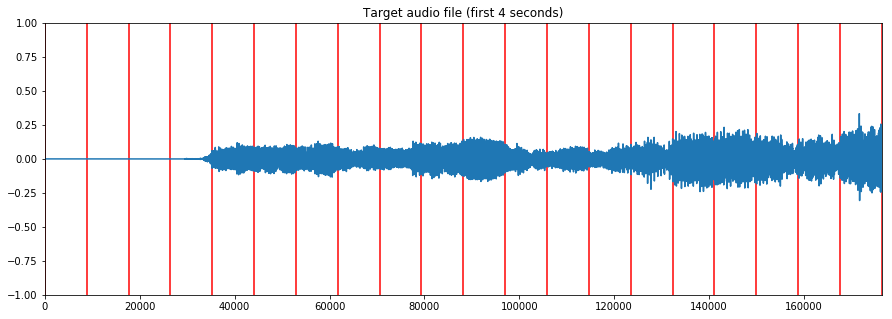

In [41]:
FRAME_SIZE = 8820
#FRAME_SIZE = 4410
#FRAME_SIZE = 2205


#Analyse sound collection

# DataFrame file of the sound source collection to analyze
DATAFRAME_FILENAME_HARMONY = 'deliverables/dataframes/dataframe_harmony.csv'  
DATAFRAME_FILENAME_DRUMS = 'deliverables/dataframes/dataframe_drums.csv'  

# DataFrame file where to store the results of our analysis
DATAFRAME_FILENAME_HARMONY_SOURCE = 'deliverables/dataframes/dataframe_harmony_source.csv'  
DATAFRAME_FILENAME_DRUMS_SOURCE = 'deliverables/dataframes/dataframe_drums_source.csv'

analyze_source_collection(DATAFRAME_FILENAME_HARMONY, DATAFRAME_FILENAME_HARMONY_SOURCE, FRAME_SIZE)
analyze_source_collection(DATAFRAME_FILENAME_DRUMS, DATAFRAME_FILENAME_DRUMS_SOURCE, FRAME_SIZE)


#analyse targets
TARGET_SOUND_PATH_BEAT = 'deliverables/target_burial_beat.wav'  # Filename of the target audio we'll reconstruct
TARGET_SOUND_PATH_NOBEAT = 'deliverables/target_spotlight_nobeat.wav'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME_BEAT = 'deliverables/dataframes/dataframe_target_burial_beat.csv'  # DataFrame file where to store the analysis results of the target audio
DATAFRAME_TARGET_FILE_FILENAME_NOBEAT = 'deliverables/dataframes/dataframe_target_spotlight_nobeat.csv'  # DataFrame file where to store the analysis results of the target audio

def analyseTargetAndPlot(target_sound_path, target_analysis_path, frame_size=8820, plot=True, log=True):
    # Analyze the target audio file and store results in a new DataFrame
    print('Analyzing target sound {0}'.format(target_sound_path))
    target_analysis = analyze_sound(target_sound_path, frame_size=frame_size)  # Also split audio in chunks of 200ms (44100/5 samples) 
    df_target = pd.DataFrame(target_analysis)
    df_target.to_csv(target_analysis_path)
    print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), target_analysis_path))

    if plot:
        # Plot target audio file waveform and show ticks at the start samples of the chunks
        plt.figure(figsize=(15,5))
        audio = estd.MonoLoader(filename=target_sound_path)()
        plt.plot(audio)
        plt.vlines(df_target['start_sample'].values, -1, 1, color='red')
        plt.axis([0, min(len(audio), 44100 * 4), -1, 1])
        plt.title('Target audio file (first 4 seconds)')
        plt.show()
    if log:
        display(df_target)  # Show data frame contents
        df_target.describe()  # Show statistics of numerical fields in data frame

print(FRAME_SIZE)
analyseTargetAndPlot(TARGET_SOUND_PATH_BEAT, DATAFRAME_TARGET_FILE_FILENAME_BEAT, FRAME_SIZE, log=False)
analyseTargetAndPlot(TARGET_SOUND_PATH_NOBEAT, DATAFRAME_TARGET_FILE_FILENAME_NOBEAT, FRAME_SIZE, log=False)


In [31]:
keys_to_number = {'C':0, 'G':1, 'D':2, 'A':3,'E':4, 'B':5, 'F#':6, 'C#':-5, 'G#':-4, 'D#':-3, 'A#':-2, 'F':-1,}
print(keys_to_number)

{'C#': -5, 'A': 3, 'D': 2, 'F#': 6, 'E': 4, 'D#': -3, 'G#': -4, 'G': 1, 'B': 5, 'F': -1, 'C': 0, 'A#': -2}


In [36]:
loader = estd.EqloudLoader(filename=TARGET_SOUND_PATH_NOBEAT)
audio = loader()
key_algo = estd.KeyExtractor()
key, scale, key_strength = key_algo(audio)
print(key)

E
